# Weather Data Preprocessing

## Set up

In [2]:
%matplotlib inline

import logging
import itertools
import json
import os
import pickle
import urllib2
import folium
import time
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from mpl_toolkits.basemap import Basemap
from datetime import datetime
from os import listdir
from os.path import isfile, join
from src.data.parse_dataset import parse_json_files, parse_json_file, get_file_list, parse_dir
from IPython.display import Image
from datetime import date

logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Data Collection

### Single Weather Station Approach

Set the time period for which data will be collected

In [3]:
#start_date = date(2016, 5, 16)
start_date = date(2016, 6, 11)
end_date = date(2016, 6, 20)

days = pd.date_range(start=start_date, end=end_date, closed='left')

Download the data from Wunderground 

In [4]:
def download(url_string, file_name):
    """Download the given resource to the given file"""
    
    response = urllib2.urlopen(url_string)
    with open(file_name, "wb") as f:
        f.write(response.read())

In [5]:
path = '/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/weather'
lhr_url = 'http://api.wunderground.com/api/8494fbcae3235601/history_%s/q/UK/London.json'

# iterate through all days and stations
for i,day in enumerate(days):
    url_string = lhr_url % (day.strftime('%Y%m%d'))
    file_name = '%s/WEATHER-%s.json' % (path, day.strftime('%Y-%m-%d'))
    
    logger.info('Downloading %s', url_string)
    download(url_string, file_name)
    
    # sleep 60 seconds every 10 requests due to API restrictions 
    if (i % 10) == 9:
        time.sleep(60)

## Data Parsing

Parse the JSON data files

In [6]:
def parse_weather(json_obj):
    """Parses Wunderground API History JSON response"""
    
    return [parse_observation(element) for element in json_obj['history']['observations']]

def parse_observation(observation):
    """Parses a JSON observation object to a dictionary"""
    
    reading = {
        'Timestamp': observation['utcdate']['pretty'],
        'Temp': observation['tempm'],
        'DewPt': observation['dewptm'],
        'Humidity': observation['hum'],
        'WindSpeed': observation['wspdm'],
        'WindDirD': observation['wdird'],
        'WindDirE': observation['wdire'],
        'Visibility': observation['vism'],
        'Pressure': observation['pressurem'],
        'WindChill': observation['windchillm'],
        'Precipitation': observation['precipm'],
        'Condition': observation['conds'],
        'Fog': observation['fog'],
        'Rain': observation['rain'],
        'Snow': observation['snow'],
        'Hail': observation['hail'],
        'Thunder': observation['thunder'],
        'Tornado': observation['tornado'],
    }

    return reading

In [7]:
def get_file_date(file_name):
    """Gets the file's date"""
    
    file_basename = os.path.basename(file_name)
    idx = file_basename.find('-')
    file_date = file_basename[idx + 1:]
    return datetime.strptime(file_date, '%Y-%m-%d.json')

Convert the raw data to a Pandas DataFrame

In [8]:
records = parse_dir('/home/jfconavarrete/Documents/Work/Dissertation/spts-uoe/data/raw/weather', 
                    parse_weather, sort_fn=get_file_date)

weather_dataset = pd.DataFrame(list(itertools.chain.from_iterable(records)))

## Technically Correct Data

In [9]:
# replace missing values
replace_empty = lambda col: col.replace('T', np.nan).replace('N/A', np.nan).replace('', np.nan)
replace_na = lambda col: col.replace('-9999.00', np.nan).replace('-9999', np.nan).replace('-9999.0', np.nan).replace('-999', np.nan)
weather_dataset = weather_dataset.apply(replace_empty, axis=1).apply(replace_na, axis=1)

# convert columns to their appropriate datatypes
weather_dataset['Fog'] = weather_dataset['Fog'].astype('bool_')
weather_dataset['Hail'] = weather_dataset['Hail'].astype('bool_')
weather_dataset['Rain'] = weather_dataset['Rain'].astype('bool_')
weather_dataset['Snow'] = weather_dataset['Snow'].astype('bool_')
weather_dataset['Tornado'] = weather_dataset['Tornado'].astype('bool_')
weather_dataset['Thunder'] = weather_dataset['Snow'].astype('bool_')

weather_dataset['Precipitation'] = weather_dataset['Precipitation'].astype('float32')
weather_dataset['Visibility'] = weather_dataset['Visibility'].astype('float32')
weather_dataset['WindChill'] = weather_dataset['WindChill'].astype('float32')
weather_dataset['WindSpeed'] = weather_dataset['WindSpeed'].astype('float32')
weather_dataset['DewPt'] = weather_dataset['DewPt'].astype('float32')
weather_dataset['Humidity'] = weather_dataset['Humidity'].astype('float32')
weather_dataset['Pressure'] = weather_dataset['Pressure'].astype('float32')
weather_dataset['Temp'] = weather_dataset['Temp'].astype('float32')
weather_dataset['WindDirD'] = weather_dataset['WindDirD'].astype('float32')

weather_dataset['Timestamp'] =  pd.to_datetime(weather_dataset['Timestamp'], format='%I:%M %p %Z on %B %d, %Y', errors='raise')

In [10]:
weather_dataset.sort_values(by=['Timestamp'], inplace=True)

## Consistent Data

Include data just between 7:00 to 23:00

In [11]:
hours = weather_dataset['Timestamp'].apply(lambda x: x.hour)
out_of_hours = weather_dataset[(hours < 7) | (hours > 22)]
weather_dataset.drop(out_of_hours.index, inplace=True)

In [12]:
out_of_hours

,Condition,DewPt,Fog,Hail,Humidity,Precipitation,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindChill,WindDirD,WindDirE,WindSpeed
0,Overcast,8.0,True,True,71.0,NaN,1022.0,True,True,12.0,True,2016-05-15 23:00:00,True,19.0,NaN,100.0,East,14.8
1,Mostly Cloudy,7.0,True,True,72.0,NaN,1021.0,True,True,12.0,True,2016-05-15 23:20:00,True,10.0,NaN,120.0,ESE,11.1
2,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-15 23:50:00,True,10.0,NaN,120.0,ESE,9.3
3,Mostly Cloudy,8.0,True,True,77.0,NaN,1022.0,True,True,11.0,True,2016-05-16 00:00:00,True,18.0,NaN,120.0,ESE,13.0
4,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-16 00:20:00,True,10.0,NaN,80.0,East,11.1
5,Unknown,8.0,True,True,82.0,NaN,1021.0,True,True,11.0,True,2016-05-16 00:50:00,True,10.0,NaN,70.0,ENE,9.3
6,Mostly Cloudy,8.0,True,True,77.0,NaN,1022.0,True,True,11.0,True,2016-05-16 01:00:00,True,17.0,NaN,60.0,ENE,9.3
7,Unknown,7.0,True,True,82.0,NaN,1021.0,True,True,10.0,True,2016-05-16 01:20:00,True,10.0,NaN,80.0,East,7.4
8,Unknown,8.0,True,True,87.0,NaN,1021.0,True,True,10.0,True,2016-05-16 01:50:00,True,10.0,NaN,80.0,East,5.6
9,Scattered Clouds,8.0,True,True,84.0,NaN,1021.0,True,True,10.0,True,2016-05-16 02:00:00,True,15.0,NaN,80.0,East,5.6


In [13]:
weather_dataset.reset_index(inplace=True, drop=True)

In [14]:
weather_dataset.shape

(1670, 18)

In [15]:
weather_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 18 columns):
Condition        1621 non-null object
DewPt            1670 non-null float32
Fog              1670 non-null bool
Hail             1670 non-null bool
Humidity         1670 non-null float32
Precipitation    0 non-null float32
Pressure         1670 non-null float32
Rain             1670 non-null bool
Snow             1670 non-null bool
Temp             1670 non-null float32
Thunder          1670 non-null bool
Timestamp        1670 non-null datetime64[ns]
Tornado          1670 non-null bool
Visibility       1666 non-null float32
WindChill        0 non-null float32
WindDirD         1670 non-null float32
WindDirE         1670 non-null object
WindSpeed        1670 non-null float32
dtypes: bool(6), datetime64[ns](1), float32(9), object(2)
memory usage: 368.2 KB


In [16]:
weather_dataset.head()

,Condition,DewPt,Fog,Hail,Humidity,Precipitation,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindChill,WindDirD,WindDirE,WindSpeed
0,Scattered Clouds,8.0,True,True,77.0,NaN,1022.0,True,True,11.0,True,2016-05-16 07:00:00,True,13.0,NaN,20.0,NNE,9.3
1,Partly Cloudy,7.0,True,True,76.0,NaN,1022.0,True,True,11.0,True,2016-05-16 07:20:00,True,10.0,NaN,30.0,NNE,9.3
2,Unknown,7.0,True,True,72.0,NaN,1022.0,True,True,12.0,True,2016-05-16 07:50:00,True,10.0,NaN,20.0,NNE,7.4
3,Scattered Clouds,7.0,True,True,64.0,NaN,1022.0,True,True,12.0,True,2016-05-16 08:00:00,True,18.0,NaN,20.0,NNE,9.3
4,Unknown,6.0,True,True,67.0,NaN,1022.0,True,True,12.0,True,2016-05-16 08:20:00,True,10.0,NaN,350.0,North,7.4


In [17]:
weather_dataset.describe()

,DewPt,Humidity,Precipitation,Pressure,Temp,Visibility,WindChill,WindDirD,WindSpeed
count,1670.000000,1670.000000,0.0,1670.000000,1670.000000,1666.000000,0.0,1670.000000,1670.000000
mean,10.741916,69.883232,NaN,1014.103577,16.092813,15.282113,NaN,164.934128,13.502928
std,2.907576,15.510112,NaN,7.567115,3.170276,10.358247,NaN,121.769863,5.440832
min,-2.000000,21.000000,NaN,995.000000,9.000000,3.100000,NaN,0.000000,1.900000
25%,9.000000,59.000000,NaN,1010.000000,14.000000,10.000000,NaN,40.000000,9.300000
50%,11.000000,72.000000,NaN,1016.000000,16.000000,10.000000,NaN,190.000000,13.000000
75%,13.000000,82.000000,NaN,1020.000000,18.000000,16.000000,NaN,260.000000,16.700001
max,19.000000,100.000000,NaN,1024.000000,25.000000,50.000000,NaN,360.000000,33.299999


In [18]:
weather_dataset.apply(lambda x:x.nunique())

Condition          20
DewPt              20
Fog                 1
Hail                1
Humidity           76
Precipitation       0
Pressure           30
Rain                1
Snow                1
Temp               17
Thunder             1
Timestamp        1670
Tornado             1
Visibility         37
WindChill           0
WindDirD           37
WindDirE           17
WindSpeed          17
dtype: int64

In [19]:
weather_dataset.isnull().sum()

Condition          49
DewPt               0
Fog                 0
Hail                0
Humidity            0
Precipitation    1670
Pressure            0
Rain                0
Snow                0
Temp                0
Thunder             0
Timestamp           0
Tornado             0
Visibility          4
WindChill        1670
WindDirD            0
WindDirE            0
WindSpeed           0
dtype: int64

### Precipitation and WindChill

We will remove the Precipitation and Windchill columns because they are mostly empty

In [20]:
weather_dataset.drop(['Precipitation', 'WindChill'], axis=1, inplace=True)

### Visibility

It can be observed that visibility has missing values, lets wee where these are missing.

In [21]:
def get_missing_indexes(df, col_name):
    # get the indexes of the missing values
    return df[df[col_name].isnull()].index

def show_before_and_after(df, indexes, num=1):
    # get one before and after each missing value and show them
    missing_slices = [(x-num, x+num) for x in missing_indexes]

    # get slices of the missing values and concatenate them
    return pd.concat([df.loc[slic[0]:slic[1]] for slic in missing_slices])

In [22]:
missing_indexes = get_missing_indexes(weather_dataset, 'Visibility')
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
727,Heavy Rain,11.0,True,True,96.0,1016.0,True,True,12.0,True,2016-05-31 11:00:00,True,5.0,350.0,North,14.8
728,Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:20:00,True,NaN,350.0,North,14.8
729,Light Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:50:00,True,10.0,360.0,North,18.5
1292,Rain,14.0,True,True,91.0,1008.0,True,True,16.0,True,2016-06-12 09:00:00,True,19.0,190.0,South,13.0
1293,Heavy Rain Showers,14.0,True,True,94.0,1008.0,True,True,15.0,True,2016-06-12 09:20:00,True,NaN,160.0,SSE,13.0
1294,Rain Showers,14.0,True,True,94.0,1008.0,True,True,15.0,True,2016-06-12 09:50:00,True,4.5,160.0,SSE,13.0
1295,Heavy Drizzle,15.0,True,True,98.0,1008.0,True,True,15.0,True,2016-06-12 10:00:00,True,4.7,160.0,SSE,13.0
1296,Rain Showers,14.0,True,True,94.0,1007.0,True,True,15.0,True,2016-06-12 10:20:00,True,NaN,170.0,South,13.0
1297,Light Rain Showers,14.0,True,True,94.0,1007.0,True,True,15.0,True,2016-06-12 10:50:00,True,6.0,190.0,South,11.1
1619,Mostly Cloudy,12.0,True,True,78.0,1024.0,True,True,15.0,True,2016-06-18 22:00:00,True,30.0,170.0,South,7.4


In [23]:
# use linear interpolation
weather_dataset['Visibility'].interpolate(inplace=True)
show_before_and_after(weather_dataset, missing_indexes)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
727,Heavy Rain,11.0,True,True,96.0,1016.0,True,True,12.0,True,2016-05-31 11:00:00,True,5.00,350.0,North,14.8
728,Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:20:00,True,7.50,350.0,North,14.8
729,Light Rain,10.0,True,True,94.0,1016.0,True,True,11.0,True,2016-05-31 11:50:00,True,10.00,360.0,North,18.5
1292,Rain,14.0,True,True,91.0,1008.0,True,True,16.0,True,2016-06-12 09:00:00,True,19.00,190.0,South,13.0
1293,Heavy Rain Showers,14.0,True,True,94.0,1008.0,True,True,15.0,True,2016-06-12 09:20:00,True,11.75,160.0,SSE,13.0
1294,Rain Showers,14.0,True,True,94.0,1008.0,True,True,15.0,True,2016-06-12 09:50:00,True,4.50,160.0,SSE,13.0
1295,Heavy Drizzle,15.0,True,True,98.0,1008.0,True,True,15.0,True,2016-06-12 10:00:00,True,4.70,160.0,SSE,13.0
1296,Rain Showers,14.0,True,True,94.0,1007.0,True,True,15.0,True,2016-06-12 10:20:00,True,5.35,170.0,South,13.0
1297,Light Rain Showers,14.0,True,True,94.0,1007.0,True,True,15.0,True,2016-06-12 10:50:00,True,6.00,190.0,South,11.1
1619,Mostly Cloudy,12.0,True,True,78.0,1024.0,True,True,15.0,True,2016-06-18 22:00:00,True,30.00,170.0,South,7.4


The interpolation values look reasonable

### Condition

It can be observed that condition has missing values, lets wee where these are missing.

In [24]:
missing_indexes = get_missing_indexes(weather_dataset, 'Condition')
show_before_and_after(weather_dataset, missing_indexes, 2)

,Condition,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
34,Partly Cloudy,6.0,True,True,52.0,1019.0,True,True,16.0,True,2016-05-16 18:20:00,True,10.0,300.0,WNW,11.100000
35,Unknown,6.0,True,True,52.0,1019.0,True,True,16.0,True,2016-05-16 18:50:00,True,10.0,360.0,North,7.400000
36,NaN,6.0,True,True,36.0,1020.0,True,True,17.0,True,2016-05-16 19:00:00,True,35.0,340.0,NNW,5.600000
37,Unknown,6.0,True,True,52.0,1019.0,True,True,16.0,True,2016-05-16 19:20:00,True,10.0,0.0,Variable,5.600000
38,Unknown,6.0,True,True,55.0,1019.0,True,True,15.0,True,2016-05-16 19:50:00,True,10.0,0.0,Variable,3.700000
37,Unknown,6.0,True,True,52.0,1019.0,True,True,16.0,True,2016-05-16 19:20:00,True,10.0,0.0,Variable,5.600000
38,Unknown,6.0,True,True,55.0,1019.0,True,True,15.0,True,2016-05-16 19:50:00,True,10.0,0.0,Variable,3.700000
39,NaN,6.0,True,True,42.0,1020.0,True,True,15.0,True,2016-05-16 20:00:00,True,45.0,30.0,NNE,3.700000
40,Unknown,6.0,True,True,55.0,1019.0,True,True,15.0,True,2016-05-16 20:20:00,True,10.0,0.0,Variable,1.900000
41,Unknown,6.0,True,True,55.0,1019.0,True,True,15.0,True,2016-05-16 20:50:00,True,10.0,0.0,Variable,3.700000


In [25]:
weather_dataset['Condition'].isnull().sum()

49

In [26]:
weather_dataset['Condition'].value_counts()

Overcast                        361
Mostly Cloudy                   321
Unknown                         265
Scattered Clouds                213
Partly Cloudy                   182
Light Rain                      132
Rain                             64
Light Rain Showers               33
Light Haze                       14
Rain Showers                      8
Thunderstorms and Rain            5
Heavy Rain                        4
Drizzle                           4
Light Thunderstorms and Rain      3
Light Drizzle                     3
Haze                              3
Mist                              2
Heavy Rain Showers                2
Clear                             1
Heavy Drizzle                     1
Name: Condition, dtype: int64

(736078.32772177411, 736156.46394489252)


(736097.6568884407, 736130.5514448925)

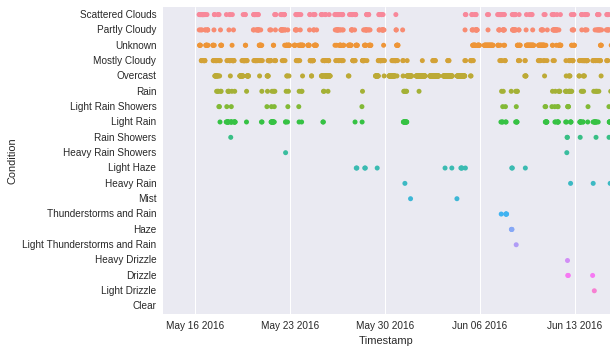

In [27]:
ax = sns.stripplot(data=weather_dataset, x='Timestamp', y='Condition', orient='h');
print ax.get_xlim()
ax.set_xlim((736097.65688844072,736130.55144489254))

**Can we do a classification model to interpolate the condition?**
Yes

**Is it worth it?**
Not sure because it would be a 'proxy' feature for all the other weather features

**Conclusion:** Drop the column

In [28]:
weather_dataset.drop(['Condition'], axis=1, inplace=True)

## Build Dataset

In [29]:
weather_dataset.head()

,DewPt,Fog,Hail,Humidity,Pressure,Rain,Snow,Temp,Thunder,Timestamp,Tornado,Visibility,WindDirD,WindDirE,WindSpeed
0,8.0,True,True,77.0,1022.0,True,True,11.0,True,2016-05-16 07:00:00,True,13.0,20.0,NNE,9.3
1,7.0,True,True,76.0,1022.0,True,True,11.0,True,2016-05-16 07:20:00,True,10.0,30.0,NNE,9.3
2,7.0,True,True,72.0,1022.0,True,True,12.0,True,2016-05-16 07:50:00,True,10.0,20.0,NNE,7.4
3,7.0,True,True,64.0,1022.0,True,True,12.0,True,2016-05-16 08:00:00,True,18.0,20.0,NNE,9.3
4,6.0,True,True,67.0,1022.0,True,True,12.0,True,2016-05-16 08:20:00,True,10.0,350.0,North,7.4


In [30]:
weather_dataset.describe()

,DewPt,Humidity,Pressure,Temp,Visibility,WindDirD,WindSpeed
count,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000,1670.000000
mean,10.741916,69.883232,1014.103577,16.092813,15.272215,164.934128,13.502928
std,2.907576,15.510112,7.567115,3.170276,10.351433,121.769863,5.440832
min,-2.000000,21.000000,995.000000,9.000000,3.100000,0.000000,1.900000
25%,9.000000,59.000000,1010.000000,14.000000,10.000000,40.000000,9.300000
50%,11.000000,72.000000,1016.000000,16.000000,10.000000,190.000000,13.000000
75%,13.000000,82.000000,1020.000000,18.000000,16.000000,260.000000,16.700001
max,19.000000,100.000000,1024.000000,25.000000,50.000000,360.000000,33.299999


In [31]:
weather_dataset.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670 entries, 0 to 1669
Data columns (total 15 columns):
DewPt         1670 non-null float32
Fog           1670 non-null bool
Hail          1670 non-null bool
Humidity      1670 non-null float32
Pressure      1670 non-null float32
Rain          1670 non-null bool
Snow          1670 non-null bool
Temp          1670 non-null float32
Thunder       1670 non-null bool
Timestamp     1670 non-null datetime64[ns]
Tornado       1670 non-null bool
Visibility    1670 non-null float32
WindDirD      1670 non-null float32
WindDirE      1670 non-null object
WindSpeed     1670 non-null float32
dtypes: bool(6), datetime64[ns](1), float32(7), object(1)
memory usage: 190.4 KB


In [32]:
pickle.dump(weather_dataset, open("data/parsed/weather_dataset_final.p", "wb"))